# import

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/sf-dst-restaurant-rating/main_task.csv
/kaggle/input/sf-dst-restaurant-rating/kaggle_task.csv
/kaggle/input/sf-dst-restaurant-rating/sample_submission.csv


In [2]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [3]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

# DATA

In [4]:
DATA_DIR = '/kaggle/input/sf-dst-restaurant-rating/'
df_train = pd.read_csv(DATA_DIR+'/main_task.csv')
df_test = pd.read_csv(DATA_DIR+'kaggle_task.csv')
sample_submission = pd.read_csv(DATA_DIR+'/sample_submission.csv')

In [5]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [6]:
col = ['Restaurant_id', 'City', 'Cuisine_Style', 'Ranking', 'Price_Range', 'Number_of_Reviews', 'Reviews', 'URL_TA', 'ID_TA','sample','Rating']
data.columns = col

In [7]:
data.info(100000)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
Restaurant_id        50000 non-null object
City                 50000 non-null object
Cuisine_Style        38410 non-null object
Ranking              50000 non-null float64
Price_Range          32639 non-null object
Number_of_Reviews    46800 non-null float64
Reviews              49998 non-null object
URL_TA               50000 non-null object
ID_TA                50000 non-null object
sample               50000 non-null int64
Rating               50000 non-null float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


# Cleaning and Prepping Data

**Проверяем столбец с Restaurant_id (идентификационный номер ресторана / сети ресторанов)**

In [8]:
data.Restaurant_id.value_counts()
# пропусков нет, все ок

print(data.Restaurant_id.describe())
# по условию - в одному id  могут быть прикреплены несколько ресторанов одной сети,
# поэтому уникальных значений меньше чем записей

data.Restaurant_id = [i[3:] for i in data.Restaurant_id]
data.Restaurant_id = [int(i) for i in data.Restaurant_id]

print(' ')
print(len(data.Restaurant_id))
print(type(data.Restaurant_id[1]))

# превратили столбец в численное выражение

count      50000
unique     13094
top       id_871
freq          19
Name: Restaurant_id, dtype: object
 
50000
<class 'numpy.int64'>


**Добавляем обозначение сетевых магазинов**

In [9]:
a=data.Restaurant_id.value_counts()
a=dict(a)
a=pd.DataFrame({'count':a}, columns=['count'])

A=a.index
B=a.values

data['chain']= data['Restaurant_id'].replace(A, B)

**Проверяем столбец с City (город, в котором находится ресторан)**

In [10]:
data.City.value_counts()
# пропусков нет, города не повторяются, проблем с ракладкой или регистром нет, все ок

print(data.City.describe())

A = list(data.City.value_counts().keys())
B = range(0, len(A))
dict_city = dict(zip(A, B))
# словарь со значениями городов

data['City_ind'] = data['City'].replace(A, B)

print(' ')
print(len(data.City_ind))
print(type(data.City_ind[1]))

# аномалий нет + мы заменили города на числовые индефикаторы

data.City.value_counts()

count      50000
unique        31
top       London
freq        7193
Name: City, dtype: object
 
50000
<class 'numpy.int64'>


London        7193
Paris         6108
Madrid        3813
Barcelona     3395
Berlin        2705
Milan         2694
Rome          2589
Prague        1816
Lisbon        1647
Vienna        1443
Amsterdam     1372
Brussels      1314
Hamburg       1186
Munich        1145
Lyon          1126
Stockholm     1033
Budapest      1021
Warsaw         925
Dublin         836
Copenhagen     819
Athens         776
Edinburgh      745
Zurich         685
Oporto         642
Geneva         590
Krakow         554
Oslo           488
Helsinki       475
Bratislava     380
Luxembourg     263
Ljubljana      222
Name: City, dtype: int64

In [11]:
A = list(data.City.value_counts().keys())
B = list(data.City.value_counts())

data['Len_rest_in_city'] = data['City'].replace(A, B)

data

data['Std_ranking']=data['Ranking']/data['Len_rest_in_city']

**Добавим столбец Residents (кол-во жителей в каждом городе)**

In [12]:
B = [8961989, 2148271, 3266126, 1636762, 3769495, 1397852, 4110000, 1324277, 506654, 1888776, 860124,
     179277, 1899160, 1471508, 481181, 975904, 1752286, 1790658, 1173179, 794128, 664046, 513210, 424008,
     237591, 201818, 779115, 693491, 643272, 432862, 626108, 295504]
dict_res = dict(zip(A, B))
# словарь со кол-вом жителей

data['Residents'] = data['City'].replace(A, B)

print(len(data.Residents))
print(type(data.Residents[1]))

50000
<class 'numpy.int64'>


**Добавим столбец Country (страна)**

In [13]:
data['Country'] = data.City
data['Country'] = data['Country'].replace('London', 'GreatBritain')
data['Country'] = data['Country'].replace('Paris', 'France')
data['Country'] = data['Country'].replace('Madrid', 'Spain')
data['Country'] = data['Country'].replace('Barcelona', 'Spain')
data['Country'] = data['Country'].replace('Berlin', 'Germany')
data['Country'] = data['Country'].replace('Milan', 'Italy')
data['Country'] = data['Country'].replace('Rome', 'Italy')
data['Country'] = data['Country'].replace('Prague', 'CzechRepublic')
data['Country'] = data['Country'].replace('Lisbon', 'Portugal')
data['Country'] = data['Country'].replace('Vienna', 'Austria')
data['Country'] = data['Country'].replace('Amsterdam', 'Netherlands')
data['Country'] = data['Country'].replace('Brussels', 'Belgium')
data['Country'] = data['Country'].replace('Hamburg', 'Germany')
data['Country'] = data['Country'].replace('Munich', 'Germany')
data['Country'] = data['Country'].replace('Lyon', 'France')
data['Country'] = data['Country'].replace('Stockholm', 'Sweden')
data['Country'] = data['Country'].replace('Budapest', 'Hungary')
data['Country'] = data['Country'].replace('Warsaw', 'Poland')
data['Country'] = data['Country'].replace('Dublin', 'Irland')
data['Country'] = data['Country'].replace('Copenhagen', 'Denmark')
data['Country'] = data['Country'].replace('Athens', 'Greece')
data['Country'] = data['Country'].replace('Edinburgh', 'Scotland')
data['Country'] = data['Country'].replace('Zurich', 'Switzeland')
data['Country'] = data['Country'].replace('Oporto', 'Portugal')
data['Country'] = data['Country'].replace('Geneva', 'Switzeland')
data['Country'] = data['Country'].replace('Krakow', 'Poland')
data['Country'] = data['Country'].replace('Oslo', 'Norway')
data['Country'] = data['Country'].replace('Helsinki', 'Finland')
data['Country'] = data['Country'].replace('Bratislava', 'Slovakia')
data['Country'] = data['Country'].replace('Luxembourg', 'Luxembourg')
data['Country'] = data['Country'].replace('Ljubljana', 'Slovenia')

A = list(data.Country.value_counts().keys())
B = range(0, len(A))
dict_country = dict(zip(A, B))
# словарь со значениями стран


data['Country_ind'] = data['Country'].replace(A, B)

print(len(data.Country_ind))
print(type(data.Country_ind[1]))

50000
<class 'numpy.int64'>


**Добавим столбик с отношением кол-ва отзывов к населению (как часто пишут их)**

In [14]:
data['Rew_of'] = data['Number_of_Reviews']/data['Residents']
data['Rew_of'] = data['Rew_of'].fillna(0)



print(len(data.Rew_of))
print(type(data.Rew_of[1]))

50000
<class 'numpy.float64'>


**Проверяем столбец с Cuisine_Style (кухня или кухни, к которым можно отнести блюда, предлагаемые в ресторане)**

In [15]:
data['Cuisine_Style'] = data['Cuisine_Style'].fillna('""No_info"')
# заменяем пропуски

new = pd.DataFrame(data.Cuisine_Style.dropna())
a = list(new.Cuisine_Style)
b = list()

def l(x):
    i = 0
    for g in x:
        f = x[i].split(',')
        v = 0
        for g in f:
            h = f[v][2:-1].replace("'", '')
            v = +1
            b.append(h)
        i += 1
        
l(a)

from collections import Counter

coun=Counter(b)
coun=dict(coun)
coun=pd.DataFrame({'count':coun}, columns=['count'])
a=coun['count'].mean()

b=list(coun.query('count > @a').index)
b

#оставляем только самые популярные кухни

def find_item(cell):
    if item in cell:
        return 1
    return 0


for item in b:
    data[item] = data['Cuisine_Style'].apply(find_item)

data['Cuisine_Style'] = data['Cuisine_Style'].apply(lambda x: len(x))

len(data['Cuisine_Style'])
# пропуски заменены, строки преобразованы в столбцы

50000

**Проверяем столбец с Price_Range (диапазон цен в ресторане)**

In [16]:
print(data.Price_Range.describe())

data['Price_Range'] = data['Price_Range'].replace('$', 1)
data['Price_Range'] = data['Price_Range'].replace('$$ - $$$', 2)
data['Price_Range'] = data['Price_Range'].replace('$$$$', 3)

a = data['Price_Range'].mean()
a = int(a)
data['Price_Range'] = data['Price_Range'].fillna(a)

print('')
print(len(data.Price_Range))
print(type(data.Price_Range[1]))
# заменили буквенные индефикаторы на численные

count        32639
unique           3
top       $$ - $$$
freq         23041
Name: Price_Range, dtype: object

50000
<class 'numpy.float64'>


**Проверяем столбец с Reviews (данные о двух отзывах, которые отображаются на сайте ресторана)**

In [17]:
print(data.Reviews.describe())

from datetime import datetime, date, time
data['Reviews'] = data.Reviews.replace("[[], []]", 'No_info')
# заменяем пропуски

data['Last_rew'] = data['Reviews']

data['Last_rew']=data['Last_rew'].str[-27:-17]

now = datetime.now()

#base['Last_rew'][base.Last_rew.str.contains("]")]=now
data['Last_rew'][data.Last_rew.str.contains("]")==True] = now
data['Last_rew'] = data['Last_rew'].fillna(now)

# приравниваем строки без даты к сегодня

data['Last_rew'] = [pd.to_datetime(i) for i in data.Last_rew]

# добавляем сколько прошло времени с момента последнего отзыва

data['Last_rew_data'] = data['Last_rew']-now
data['Last_rew_data'] = [i.total_seconds() for i in data.Last_rew_data]
data['Last_rew_data'] = data['Last_rew_data']
data['Last_rew_data'] = data['Last_rew_data'].fillna(0)



print('')
print(len(data.Last_rew_data))
print(type(data.Last_rew_data[1]))

count        49998
unique       41857
top       [[], []]
freq          8112
Name: Reviews, dtype: object


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  



50000
<class 'numpy.float64'>


**Проверяем столбец с Number_of_Reviews (количество отзывов о ресторане)**

In [18]:
from datetime import datetime, date, time

m=data['Number_of_Reviews'].mean()

print(data['Number_of_Reviews'].describe())
# отрицательных чисел нет

data['Number_of_Reviews'].value_counts()
# но есть пропуски, нужно проверить, что где есть пропуски - там действительно нет отзывов

data['Number_of_Reviews'] = data['Number_of_Reviews'].fillna('No_info')
# меняем пропуски на Not_info

a = data.query('Reviews == "No_info" & Number_of_Reviews == "No_info"')
b = list(a.index)
data['Number_of_Reviews'][b] = 0
# где нет значения кол-ва отзывов и превью отзывов - ставим 0

len(data['Number_of_Reviews'])
# заменили предполагаемые пропуски, в некоторые смогли подставить значения. С 2,5+ тысяч снизили пропуски до 900+

data['Number_of_Reviews'] = data['Price_Range'].replace('No_info', m)

# пропуски, которые не смогли заполнить, заполняем средним значением

#data.Number_of_Reviews = [float(i) for i in data.Number_of_Reviews]

print('')
print(len(data.Number_of_Reviews))
print(type(data.Number_of_Reviews[1]))

count    46800.000000
mean       124.471197
std        294.114345
min          2.000000
25%          9.000000
50%         33.000000
75%        115.000000
max       9660.000000
Name: Number_of_Reviews, dtype: float64

50000
<class 'numpy.float64'>


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


**проверяем м столбец с ID_TA (идентификатор ресторана в базе данных TripAdvisor)**

In [19]:
print(data['ID_TA'].describe())

data['ID_TA']=data['ID_TA'].str[1:]
data.ID_TA = [float(i) for i in data.ID_TA]

print('')
print(len(data.ID_TA))
print(type(data.ID_TA[1]))

count        50000
unique       49963
top       d4748208
freq             2
Name: ID_TA, dtype: object

50000
<class 'numpy.float64'>


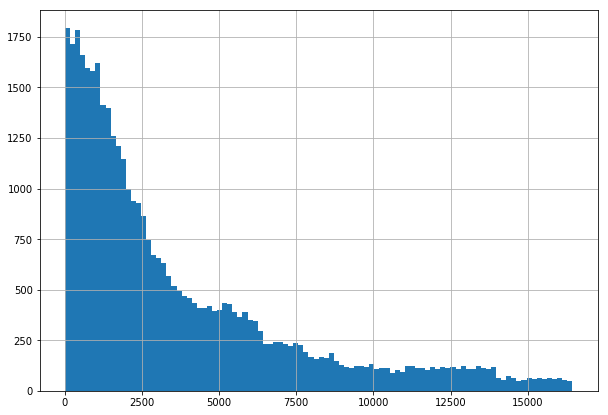

In [20]:
plt.rcParams['figure.figsize'] = (10,7)
df_train['Ranking'].hist(bins=100)

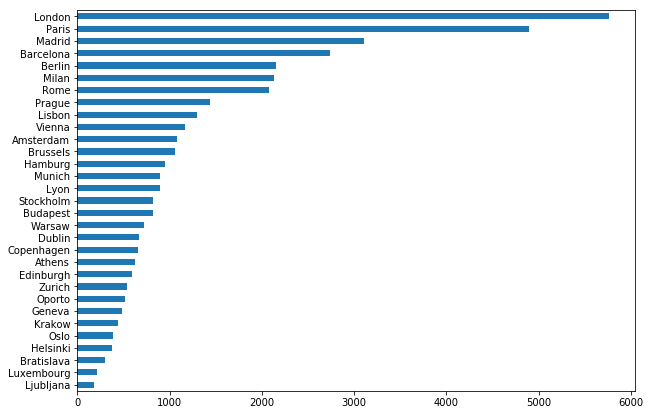

In [21]:
df_train['City'].value_counts(ascending=True).plot(kind='barh')

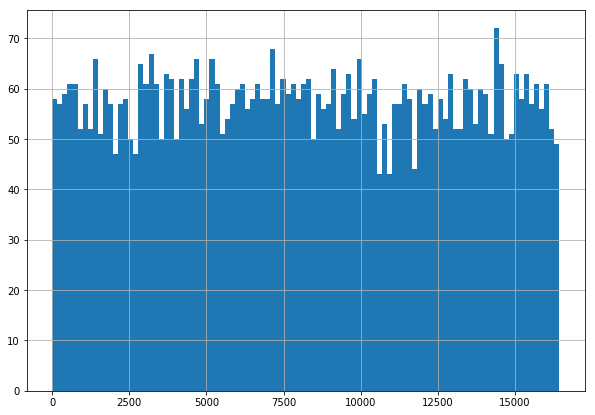

In [22]:
df_train['Ranking'][df_train['City'] =='London'].hist(bins=100)

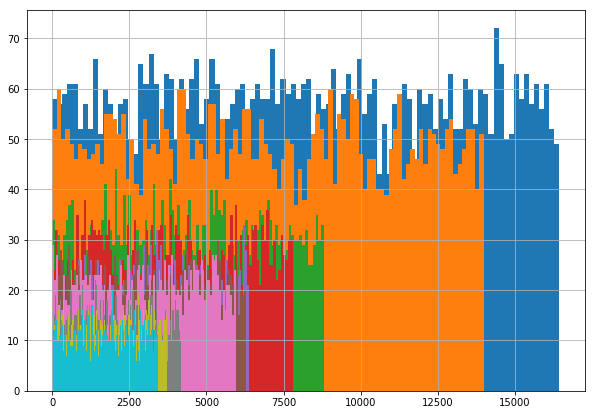

In [23]:
# посмотрим на топ 10 городов
for x in (df_train['City'].value_counts())[0:10].index:
    df_train['Ranking'][df_train['City'] == x].hist(bins=100)
plt.show()

### Посмотрим распределение целевой переменной

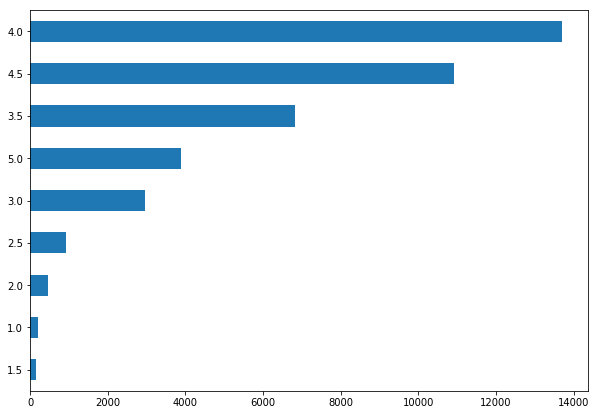

In [24]:
df_train['Rating'].value_counts(ascending=True).plot(kind='barh')

### Посмотрим распределение целевой переменной относительно признака

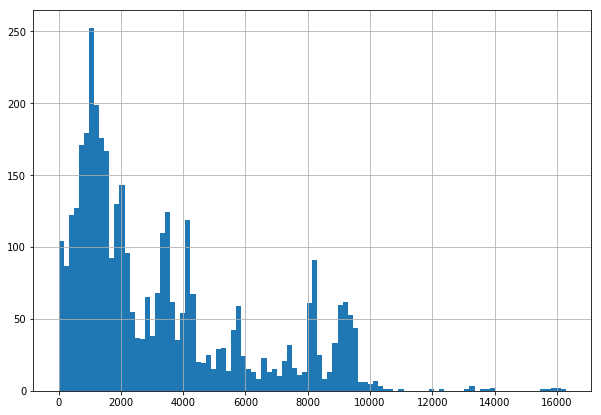

In [25]:
df_train['Ranking'][df_train['Rating'] == 5].hist(bins=100)

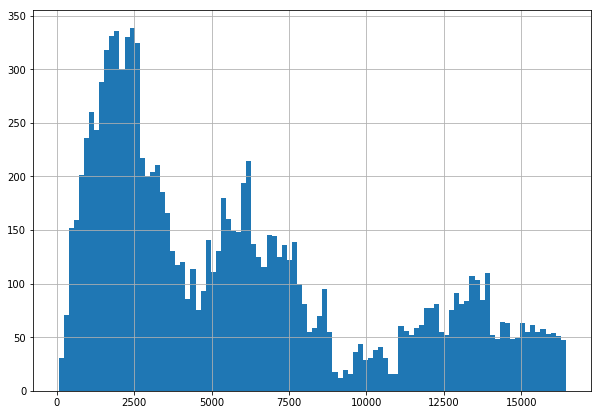

In [26]:
df_train['Ranking'][df_train['Rating'] < 4].hist(bins=100)

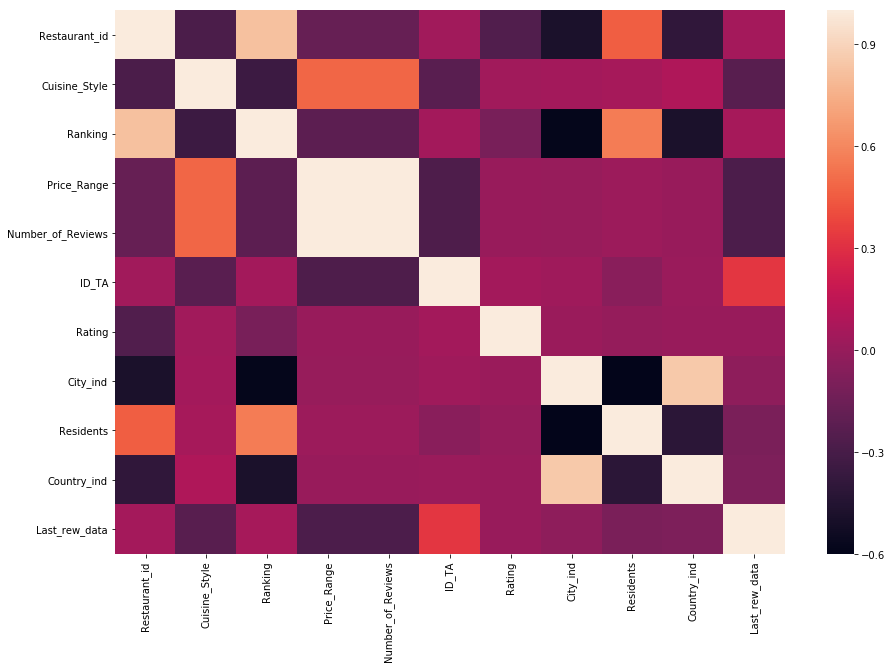

In [27]:
data1=data
col= ['Restaurant_id', 'Cuisine_Style', 'Ranking', 'Price_Range',
       'Number_of_Reviews', 'ID_TA', 'sample', 'Rating', 'City_ind',
       'Residents', 'Country_ind','Last_rew_data']

plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(data1[col].drop(['sample'], axis=1).corr(),)

# Data Preprocessing

In [28]:
data = data.drop('URL_TA', axis=1)
data = data.drop('Reviews', axis=1)
data = data.drop('Last_rew', axis=1)
data = data.drop('City', axis=1)
data = data.drop('Country', axis=1)
data = data.drop('Restaurant_id', axis=1)
data = data.drop('Cuisine_Style', axis=1)

In [29]:
data = data.drop('Len_rest_in_city', axis=1)

In [30]:
data = data.drop('chain', axis=1)

In [31]:
pd.options.display.max_info_columns 
data.info(verbose=True, max_cols=False, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 34 columns):
Ranking                50000 non-null float64
Price_Range            50000 non-null float64
Number_of_Reviews      50000 non-null float64
ID_TA                  50000 non-null float64
sample                 50000 non-null int64
Rating                 50000 non-null float64
City_ind               50000 non-null int64
Std_ranking            50000 non-null float64
Residents              50000 non-null int64
Country_ind            50000 non-null int64
Rew_of                 50000 non-null float64
American               50000 non-null int64
Asian                  50000 non-null int64
Bar                    50000 non-null int64
British                50000 non-null int64
Cafe                   50000 non-null int64
Chinese                50000 non-null int64
European               50000 non-null int64
Fast Food              50000 non-null int64
French                 50000 non-null int

In [32]:
# Теперь выделим тестовую часть
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample'], axis=1)

y = train_data.Rating.values            # наш таргет
X = train_data.drop(['Rating'], axis=1)

**Перед тем как отправлять наши данные на обучение, разделим данные на еще один тест и трейн, для валидации. 
Это поможет нам проверить, как хорошо наша модель работает, до отправки submissiona на kaggle.**

In [33]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [34]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((10000, 33), (40000, 33), (40000, 32), (32000, 32), (8000, 32))

# Model 
Сам ML

In [35]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [36]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [37]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    7.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [38]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.20447625


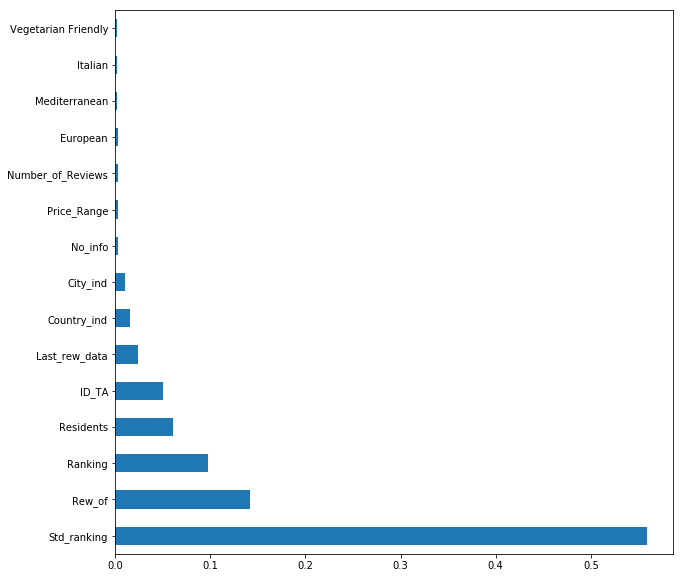

In [39]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

# Submission
Если все устраевает - готовим Submission на кагл

In [40]:
test_data.sample(10)
test_data = test_data.drop(['Rating'], axis=1)

In [41]:
len(test_data)

10000

In [42]:
len(sample_submission)

10000

In [43]:
predict_submission = model.predict(test_data)
len(predict_submission)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


10000

In [44]:
sample_submission['Rating'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,Restaurant_id,Rating
0,id_0,3.010
1,id_1,4.345
2,id_2,4.205
3,id_3,4.445
4,id_4,4.295
5,id_5,4.430
6,id_6,1.955
7,id_7,2.075
8,id_8,4.160
9,id_9,4.555
